In [1]:
import corneto as cnt
import numpy as np

cnt.info()

CORNETO v0.9.1-alpha.0 (up to date)
Available backends:  CVXPY v1.3.0, PICOS v2.4.1
Default backend (corneto.K): CVXPY
Available solvers for CVXPY: CBC, CPLEX, CVXOPT, ECOS, ECOS_BB, GLPK, GLPK_MI, GUROBI, MOSEK, OSQP, SCIP, SCIPY, SCS
https://github.com/saezlab/corneto


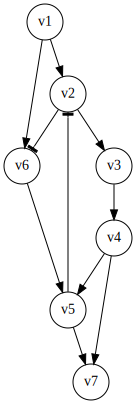

In [2]:
G = cnt.Graph.from_sif_tuples(
    [
        ('v1', 1, 'v2'),
        ('v1', 1, 'v6'),
        ('v2', 1, 'v3'),
        ('v2', -1, 'v6'),
        ('v3', 1, 'v4'),
        ('v4', 1, 'v5'),
        ('v5', -1, 'v2'),
        ('v6', 1, 'v5'),
        ('v4', 1, 'v7'),
        ('v5', 1, 'v7')
    ]
)
data = {
    'tp1': {
        'v1': ('P', 1),
        'v7': ('M', 1),
        'v2': ('M', 1)
    },
    'tp2': {
        'v1': ('P', 1),
        'v7': ('M', -1),
        'v2': ('M', -1)
    }
}
G.to_graphviz()

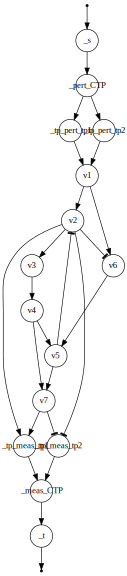

In [3]:
from corneto import create_flow_graph
t1 = {'CTP': data['tp1']}
t2 = {'CTP': data['tp2']}
timepoints = [t1, t2]
Gf = create_flow_graph(G, data, longitudinal_samples=True)
Gf.to_graphviz(graph_attr=dict(size="8"))

In [4]:
from corneto import signflow_constraints, default_sign_loss, hamming_loss
import pandas as pd

reg_penalty=0.1
dist_penalty=0.0
max_time=3600
gap=0.0
norel=0
sol_edges, sol_nodes = [], []
flow_values = []
# Sequential optimization
base_problem = signflow_constraints(Gf, dag=True)
prev_sol = None
problems = [base_problem]
for t in timepoints:
    p = base_problem + default_sign_loss(t, base_problem, l0_edges=reg_penalty)
    curr_sol = p.symbols['reaction_sends_activation_CTP'] + p.symbols['reaction_sends_inhibition_CTP']
    if prev_sol is not None:
        p += hamming_loss(prev_sol, curr_sol, penalty=dist_penalty)
    p.solve(solver='GUROBI', verbosity=0, max_seconds=max_time, MIPGap=gap, NoRelHeurTime=norel);
    problems.append(p)
    if prev_sol is not None:
        print("hamming distance:", sum(abs(curr_sol.value - prev_sol)))
    if len(p.objectives) > 1:
        print(p.objectives[0].value, p.objectives[1].value)
    prev_sol = np.abs(np.array(curr_sol.value))
    # Store solution (edge values and node values)
    edge_vals = p.symbols['reaction_sends_activation_CTP'].value - p.symbols['reaction_sends_inhibition_CTP'].value
    node_vals = p.symbols['species_activated_CTP'].value - p.symbols['species_inhibited_CTP'].value
    flow_values.append(pd.DataFrame(p.symbols['_flow_rxn_ipos'].value, index=Gf.edges))
    sol_edges.append(pd.DataFrame(edge_vals, index=Gf.edges))
    sol_nodes.append(pd.DataFrame(node_vals, index=Gf.vertices))
    #break

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-09
[0.] 12.0
hamming distance: 8.0
[0.] 14.0


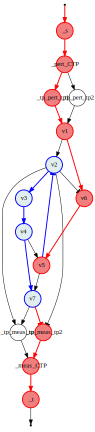

In [5]:
Gf.to_graphviz(problem=base_problem, condition='CTP', graph_attr=dict(size="6"))